In [49]:
%load_ext autoreload
%autoreload 2
from add_thin.data import DataModule
from pathlib import Path
import torch
import torch.nn as nn
import math
from add_thin.diffusion.model import AddThin
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.distributions as D
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import time
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import MLP
from torchcfm.models.models import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
dm = DataModule(root=Path('data'), name="taxi",
                train_size=0.6, val_size=0.2,batch_size=128)
dm.prepare_data()

In [157]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [159]:
class Time_embed(nn.Module):
    def __init__(self, d_model):
        super(Time_embed, self).__init__()
        self.d_model = d_model

        
    def forward(self, x):
        x_time = x.time
        x_time = x_time.to(device)
        result = x_time.unsqueeze(-1).repeat(1, 1, self.d_model)
        result[:, :, 0::2] = torch.sin(result[:, :, 0::2])
        result[:, :, 1::2] = torch.cos(result[:, :, 1::2])
        mask = x.mask.unsqueeze(-1).float()
        return result * mask

In [160]:
class N_embed(nn.Module):
    def __init__(self, d_model):
        super(N_embed, self).__init__()
        self.d_model = d_model
        self.encoder_fc1 = nn.Linear(1, d_model)
        self.encoder_fc2 = nn.Linear(d_model, d_model)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.to(device)
        x = x.unsqueeze(-1)
        x1 = F.relu(self.encoder_fc1(x))
        x2 = self.encoder_fc2(x1)
        result = x1 + x2
        return result
    
    def decode(self, x):
        x = x.to(device)
        x = self.decoder(x)
        return x

In [218]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2 * dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x, context,t):
        t = t.view(-1, 1,1).repeat(1, x.shape[1], 1)
        context = context.unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat([x, context, t], dim=-1)
        
        return self.net(x)

In [219]:
class PredictPossionRate(nn.Module):
    def __init__(self, 
                 d_model, 
                 nhead, 
                 dim_feedforward, 
                 dropout, 
                 batch_first,
                 num_layers = 3):
        super(PredictPossionRate, self).__init__()
        
        self.transformer_encoder_layer = TransformerEncoderLayer(d_model = d_model,
                                        nhead = nhead,
                                        dim_feedforward = dim_feedforward,
                                        dropout = dropout,
                                        batch_first = batch_first)
        
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers)
        
        
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        self.time_encoder = Time_embed(d_model)
        self.kept_embs = nn.Embedding(2, d_model)
        self.n_embed = N_embed(d_model)
        self.mlp = MLP(dim= d_model, time_varying=True)
        
        
        
    def forward(self, x,n):
        
        time_embeds = self.time_encoder(x)
        pad_mask = x.mask.unsqueeze(-1).float()
        x_kept_cond = x.kept
        if x.kept is not None:
            kept_mask = x.kept.long()
            kept_embs = self.kept_embs(kept_mask)
            pm = pad_mask.repeat(1,1,kept_embs.shape[-1])
            kept_embs = kept_embs * pm
        n = self.n_embed(n).unsqueeze(1)
        if x.kept is not None:
            concat_embeds = time_embeds + kept_embs + n
        else:
            concat_embeds = time_embeds + n
        #concat_embeds = time_embeds * kept_embs + n
        b,seq_len, d_model = time_embeds.shape
        mask = torch.zeros((seq_len, seq_len), device = x.time.device)
        pad_mask = pad_mask.squeeze(-1)
        pad_mask[pad_mask == 0] = float('-inf')
        pad_mask[pad_mask == 1] = 0
        transformer_embeds = self.transformer_encoder(concat_embeds, 
                                                      mask = mask,
                                                      src_key_padding_mask = pad_mask)
        avg_emb = transformer_embeds.sum(1) / torch.clamp(x.mask.sum(-1)[..., None], min=1)
        return avg_emb
    

In [220]:
d_model = 8
nhead = 2
dim_feedforward = 32
dropout = 0.0
batch_first = True
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_seq_len =dm.n_max
add_thin_model = AddThin(classifier_model =None,
        intensity_model = None,
        max_time = 100,
        n_max = dm.n_max,
        steps = 1,
        hidden_dims = d_model,
        emb_dim = d_model,
        encoder_layer = 3,
        kernel_size =  5,
        forecast=None,
        simulation_steps = 10,
).to(device)
mlp = MLP(dim= d_model, time_varying=True).to(device)
time_embed = N_embed(d_model).to(device)
optimizer = optim.Adam(list(add_thin_model.parameters()) + list(mlp.parameters()) + list(time_embed.parameters()), lr=0.001)
FM = ConditionalFlowMatcher(sigma=0.001)
node = NeuralODE(mlp, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [221]:
from tqdm import tqdm
from IPython.display import clear_output
from torch.distributions import Poisson


In [330]:
#set detect anomaly to True
with torch.autograd.detect_anomaly():
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(1)):
        train_batch_list = []
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            n = torch.randint(low = 0, high = add_thin_model.simulation_steps, size=(len(batch),), device=batch.time.device)
            n = n/add_thin_model.simulation_steps
            x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
            x_n.to(device)
            x_0_thin.to(device)
            (flow_time_emb, x_n_emb) = add_thin_model.compute_emb(n=n, x_n=x_n)
            avg_emb = x_n_emb.sum(1) / torch.clamp(x_n.mask.sum(-1)[..., None], min=1)
            combined_emb = avg_emb + flow_time_emb
            thin_time = x_0_thin.time
            thin_time = thin_time/batch.tmax
            thin_time = thin_time
            time_embs = time_embed(thin_time)
            x_0_thin_mask = x_0_thin.mask.unsqueeze(-1)
            t_0 = torch.rand_like(time_embs) * x_0_thin_mask
            t_1 = time_embs * x_0_thin_mask
            
            t, xt, ut = FM.sample_location_and_conditional_flow(x0=t_0, x1=t_1)
            t = t.to(add_thin_model.device)
            xt = xt.to(add_thin_model.device)
            ut = ut.to(add_thin_model.device)
            vt = mlp(xt, combined_emb, t)
            loss_time = torch.mean((vt - ut) ** 2)
            
            decoded_time = time_embed.decode(time_embs).squeeze()
            decoded_time_loss = F.mse_loss(decoded_time, thin_time.squeeze())
            total_time_loss = loss_time + decoded_time_loss
            
            unpadded_lens = batch.unpadded_length.float() / add_thin_model.n_max
            x_1 = add_thin_model.process_time_embed(unpadded_lens)
            decoded_lens = add_thin_model.process_time_embed.decode(x_1).squeeze()
            x_0 = torch.rand_like(x_1)
            t, xt, ut = add_thin_model.FM.sample_location_and_conditional_flow(x0=x_0, x1=x_1)
            t = t.to(add_thin_model.device)
            xt = xt.to(add_thin_model.device)
            ut = ut.to(add_thin_model.device)
            if add_thin_model.forecast:
                vt = add_thin_model.mlp(xt, add_thin_model.history, t)
            else:
                vt = add_thin_model.mlp(xt, t)
            decode_loss = F.mse_loss(decoded_lens, unpadded_lens)
            fm_loss = torch.mean((vt - ut) ** 2)
            loss = fm_loss + decode_loss + total_time_loss
            loss.backward()
            optimizer.step()
            train_batch_list.append(loss.item())
            
            
            
        with torch.no_grad():
            #evaluate on val_loader
            val_batch_list = []
            for batch in val_loader:
                batch.to(device)
                n = torch.randint(low = 0, high = add_thin_model.simulation_steps, size=(len(batch),), device=batch.time.device)
                n = n/add_thin_model.simulation_steps
                x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
                x_n.to(device)
                x_0_thin.to(device)
                (flow_time_emb, x_n_emb) = add_thin_model.compute_emb(n=n, x_n=x_n)
                avg_emb = x_n_emb.sum(1) / torch.clamp(x_n.mask.sum(-1)[..., None], min=1)
                combined_emb = avg_emb + flow_time_emb
                thin_time = x_0_thin.time
                thin_time = thin_time/batch.tmax
                thin_time = thin_time
                time_embs = time_embed(thin_time)
                x_0_thin_mask = x_0_thin.mask.unsqueeze(-1)
                t_0 = torch.rand_like(time_embs) * x_0_thin_mask
                t_1 = time_embs * x_0_thin_mask
                t, xt, ut = FM.sample_location_and_conditional_flow(x0=t_0, x1=t_1)
                t = t.to(add_thin_model.device)
                xt = xt.to(add_thin_model.device)
                ut = ut.to(add_thin_model.device)
                vt = mlp(xt, combined_emb, t)
                loss_time = torch.mean((vt - ut) ** 2)
                decoded_time = time_embed.decode(time_embs).squeeze()
                decoded_time_loss = F.mse_loss(decoded_time, thin_time.squeeze())
                total_time_loss = loss_time + decoded_time_loss
                

            
                unpadded_lens = batch.unpadded_length.float() / add_thin_model.n_max
                x_1 = add_thin_model.process_time_embed(unpadded_lens)
                decoded_lens = add_thin_model.process_time_embed.decode(x_1).squeeze()
                x_0 = torch.rand_like(x_1)
                t, xt, ut = add_thin_model.FM.sample_location_and_conditional_flow(x0=x_0, x1=x_1)
                t = t.to(add_thin_model.device)
                xt = xt.to(add_thin_model.device)
                ut = ut.to(add_thin_model.device)
                if add_thin_model.forecast:
                    vt = add_thin_model.mlp(xt, add_thin_model.history, t)
                else:
                    vt = add_thin_model.mlp(xt, t)
                decode_loss = F.mse_loss(decoded_lens, unpadded_lens)
                fm_loss = torch.mean((vt - ut) ** 2)
                loss = fm_loss + decode_loss + total_time_loss
                val_batch_list.append(loss.item())
                
                
                
            
        train_loss_list.append(sum(train_batch_list)/len(train_batch_list))
        val_loss_list.append(sum(val_batch_list)/len(val_batch_list))
        if epoch % 10 == 0:
                #clear output of jupyter notebook screen
                clear_output(wait=True)
                print("epoch: ", epoch, "val_loss: ", val_loss_list[-1])

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

epoch:  0 val_loss:  0.006971920840442181


In [331]:
add_thin_model.eval()
mlp.eval()
time_embed.eval()

N_embed(
  (encoder_fc1): Linear(in_features=1, out_features=8, bias=True)
  (encoder_fc2): Linear(in_features=8, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [332]:
t.shape

torch.Size([36])

In [341]:
from add_thin.data import Batch

In [342]:
import torchdiffeq

for batch in test_loader:
    batch.to(device)
    n = torch.randint(low = 9, high = add_thin_model.simulation_steps, size=(len(batch),), device=batch.time.device)
    n = n/add_thin_model.simulation_steps
    x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
    x_n.to(device)
    x_0_thin.to(device)
    (flow_time_emb, x_n_emb) = add_thin_model.compute_emb(n=n, x_n=x_n)
    avg_emb = x_n_emb.sum(1) / torch.clamp(x_n.mask.sum(-1)[..., None], min=1)
    combined_emb = avg_emb + flow_time_emb
    context = combined_emb
    max_len = c = max(x_0_thin.unpadded_length)
    b = x_0_thin.time.shape[0]
    d = d_model
    actual_lens = x_0_thin.unpadded_length.float()
    
    with torch.no_grad():
        traj = torchdiffeq.odeint(
            lambda t, x: mlp.forward(x, context, t.repeat(x.shape[0],)),
            torch.rand(size=(b, 2 * c,d), device=device),
            torch.linspace(0, 1, 10, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
        tmax = x_0_thin.tmax
        
        out = traj[-1,:,:]
        out = time_embed.decode(out).squeeze() * batch.tmax
        out = out.detach()
        times = out
        inside = torch.logical_and(times <= tmax, times >= 0)
        sort_idx = torch.argsort(
            inside.int(), stable=True, descending=True, dim=-1
        )
        inside = torch.take_along_dim(inside, sort_idx, dim=-1)[
            :, :max_seq_len
        ]
        times = torch.take_along_dim(times, sort_idx, dim=-1)[
            :, :max_seq_len
        ]

        # Randomly mask out events exceeding the actual sequence length
        mask = (
            torch.arange(0, times.shape[-1], device=times.device)[None, :]
            < actual_lens[:, None]
        )
        
        mask = mask * inside
        
        if (mask.sum(-1) == actual_lens).all():
            print("okay")
        else:
            print("not all elements are equal")

        times = times * mask.float()
        
        a =  Batch.remove_unnescessary_padding(
            time=times, mask=mask, tmax=tmax, kept=None
        )
        

okay


In [347]:
a.time[0]

tensor([1.3891, 2.3856, 2.9051, 3.3039, 3.3936, 3.7033, 3.9046, 4.0879, 5.4984,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [348]:
x_0_thin.time[0]

tensor([1.2075, 1.2331, 5.6717, 5.8172, 6.0267, 6.6608, 6.8386, 7.1108, 7.7050,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [290]:
actual_lens

tensor([ 8.,  7., 10., 10., 10.,  9., 13., 11.,  8.,  9.,  6., 11., 11., 10.,
        10.,  8.,  7., 10., 10., 11., 12., 10., 10., 11., 12.,  9.,  8., 13.,
         7.,  7., 12.,  8., 10., 12., 11., 13.,  7.], device='cuda:0')

In [291]:
mask

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]], device='cuda:0')

In [292]:
ind = torch.argmax(x_0_thin.unpadded_length)

In [293]:
x_0_thin.time[ind]

tensor([13.0269, 13.0886, 13.1458, 13.3092, 13.3886, 13.5336, 13.9692, 14.2828,
        14.3269, 14.5108, 14.6544, 14.6894, 15.1350,  0.0000], device='cuda:0')

In [297]:
torch.sort(times[ind], descending=True)

torch.return_types.sort(
values=tensor([16.9488, 16.7257, 16.1796, 15.6667, 15.5336, 15.1370, 14.6748, 14.3598,
        13.5497, 13.0320, 13.0183, 13.0092, 10.7087,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0'),
indices=tensor([ 6,  9,  7, 12, 11,  0,  1,  4,  8, 10,  2,  3,  5, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
       device='cuda:0'))

In [228]:
out_4 = out * 4

In [ ]:
#perform rehection sampling on out_4. select the number of elements according to the actual_lens
#out_4 shape is (b,c)
#actual_lens shape is (b,)
#perform rejection sampling on out_4
#Randomly select the number of elements according to the actual_lens from

In [ ]:
seq_lens = np.array([])
for batch in test_loader:
    n = torch.randint(low = 0, high = add_thin_model.simulation_steps, size=(len(batch),), device=batch.time.device) * 0
    n = n/add_thin_model.simulation_steps
    x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
    

    
    
    

In [145]:
len(seq_lens)

37

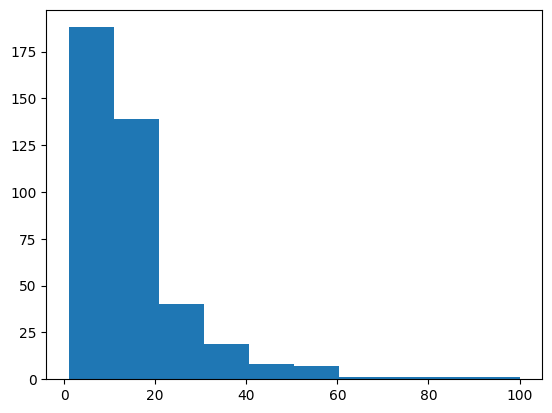

In [335]:
#plot histogram of seq_lens
plt.hist(seq_lens)
plt.show()

In [336]:
predicted_lens = np.array([])
actual_lens = np.array([])

import torchdiffeq

for batch in test_loader:
    n = torch.randint(low = 9, high = 10, size=(len(batch),), device=batch.time.device) * 0
    n = n/10 
    x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
    x_n.to(device)
    x_0_thin.to(device)
    unpadded_lens = x_0_thin.unpadded_length.float()/max_seq_len
    x_1 = model.n_embed(unpadded_lens)
    context = model(x_n,n)
    
    
    with torch.no_grad():
        traj = torchdiffeq.odeint(
            lambda t, x: model.mlp.forward(x, context, t.view(-1,).repeat(x.shape[0],)),
            torch.rand_like(x_1, device=device),
            torch.linspace(0, 1, 10, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
        
        out = traj[-1,:,:]
        out = model.n_embed.decode(out).squeeze() * dm.n_max
        out = out.cpu().detach().numpy()
        predicted_lens = np.concatenate([predicted_lens, out])
        actual_lens = np.concatenate([actual_lens, x_0_thin.unpadded_length.cpu().detach().numpy()])

In [337]:
np.round(predicted_lens)

array([20.,  9.,  8.,  9.,  6.,  6., 12., 19., 11., 26.,  5., 10.,  7.,
       11.,  4., 18., 41., 16.,  9.,  7., 21., 47., 12., 18.,  9., 26.,
        6., 16.,  9., 18., 37., 11.,  8., 23.,  8., 19., 13., 18., 17.,
        9., 19., 26., 17., 30., 42.,  8., 32., 19., 16., 13., 11., 14.,
       13., 24., 15., 22.,  7., 14., 13., 27., 36., 27., 31., 12., 20.,
        7., 43., 28., 13., 15., 12., 10.,  6.,  7.,  9., 12.,  7.,  5.,
       11., 12.,  6., 11., 47., 24., 21., 17., 29.,  2.,  8., 25., 17.,
       16.,  5., 14.,  5., 19., 25., 17., 29., 11., 53.,  7., 39., 11.,
       21., 15., 10., 16., 11.,  5.,  8., 12.,  8.,  8.,  9., 22., 38.,
        7.,  9., 15.,  6., 12., 11., 12., 11., 16., 12., 10., 14., 12.,
       15., 14., 12.,  5., 13.,  6., 10., 11.,  5.,  5., 27.,  4., 21.,
        8., 25., 14.,  9., 64., 14., 38., 10.,  9.,  9., 86., 27.,  9.,
       16.,  8., 12., 19., 15., 11., 13., 16., 12.,  4., 16., 24., 20.,
       11., 14.,  7., 17.,  9., 17., 15.,  6., 12., 12.,  8., 16

In [338]:
actual_lens

array([ 44.,  21.,   1.,   7.,   9.,   7.,   4.,  24.,  12.,   7.,  11.,
         8.,  11.,   1.,   1.,  27.,   1.,   1.,   1.,  18.,   1.,  19.,
        29.,   3.,  15.,  13.,   4.,  15.,  10.,   8.,   4.,   1.,  19.,
         8.,  14.,   2.,  13.,  10.,  15.,  43.,   5.,   4.,  33.,   7.,
         5.,  26.,   1.,   1.,   8.,   1.,   1.,  11.,  15.,   5.,   6.,
        11.,  29.,   6.,  39.,   1.,  24.,   6.,   5.,   7.,  11.,  10.,
        17.,  15.,  25.,   6.,   1.,  13.,  19.,   1.,  13.,   1.,   4.,
        29.,  17.,  30.,   2.,  11.,   9.,  19.,   1.,  18.,  53.,   3.,
         1.,  14.,   8.,  16.,   1.,   5.,  13.,  10.,   1.,   1.,  14.,
        19.,   1.,  14.,  11.,   9.,   8.,  23.,  13.,  12.,  28.,  28.,
        17.,  38.,   9.,  16.,   1.,  11.,  29.,   5.,  18.,   1.,   1.,
         9.,   2.,   7.,  27.,   5.,   2.,   9.,  35.,  12.,  13.,   1.,
        15.,   3.,   2.,   3.,  21.,   3.,   7.,   1.,  14.,  24.,  12.,
        42.,  12.,  21.,  11.,   6.,  27.,  34.,  1

In [339]:
np.mean(abs(actual_lens - predicted_lens))

11.804365136299603

In [340]:
"""node = NeuralODE(
                    torch_wrapper(model.mlp), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
                )
with torch.no_grad():
    traj = node.trajectory(
        torch.rand(size = (1000,16), device = device),
        t_span=torch.linspace(0, 1, 20),
    )
    
out = traj[-1,:,:]
out = model.n_embed.decode(out).squeeze() * dm.n_max
out = out.cpu().detach().numpy()
"""

'node = NeuralODE(\n                    torch_wrapper(model.mlp), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4\n                )\nwith torch.no_grad():\n    traj = node.trajectory(\n        torch.rand(size = (1000,16), device = device),\n        t_span=torch.linspace(0, 1, 20),\n    )\n    \nout = traj[-1,:,:]\nout = model.n_embed.decode(out).squeeze() * dm.n_max\nout = out.cpu().detach().numpy()\n'

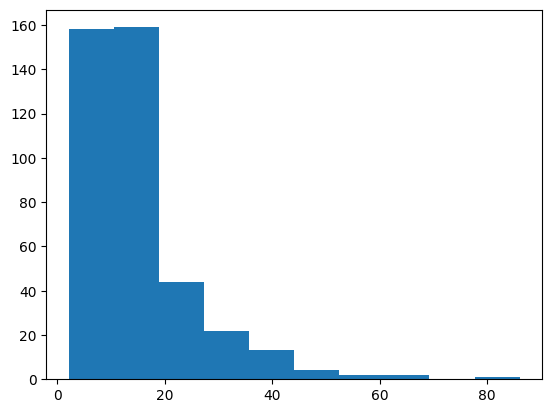

In [341]:
#plot histogram of out
plt.hist(predicted_lens)
plt.show()

In [342]:
from scipy.stats import wasserstein_distance
actual = seq_lens/dm.n_max
predicted = predicted_lens/dm.n_max
result = wasserstein_distance(actual, predicted)
print("Wasserstein Distance is: ", result)


Wasserstein Distance is:  0.01244014417361426


In [554]:


n = torch.randint(low = 0,high=1,size=(len(batch),), device=batch.time.device)
#n[:l//3] = n[:l//3] * 3
#n[l//3:2*l//3] =  n[l//3:2*l//3] * 2
#n[2*l//3:] = n[2*l//3:] * 1
n = n/10
x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
x_n.to(device)
x_0_thin.to(device)
context_embs = context(x_n,n)

x_recon = vae.sample(context_embs)
lens = torch.round(140 * x_recon)
lens = lens.squeeze()
actual_lens = x_0_thin.mask.sum(-1).float()

NameError: name 'context' is not defined

In [ ]:
lens

In [ ]:
abs(lens - actual_lens)

In [ ]:
n

In [65]:
lens[-12]

tensor(55., device='cuda:0', grad_fn=<SelectBackward0>)

In [66]:
actual_lens[-12]

tensor(116., device='cuda:0')

In [152]:
x_0_thin.unpadded_length

tensor([ 34,  35,  43, 103,  59,  99,   8,  72,  93,  14,  31,  31,  19,  79,
         77,  68,  22,  83,  52,  20,  66,  67,  72,  26,  70,  22,  12,  59,
         58,  66,  95,  57,   9,  18,  63,  90], device='cuda:0')

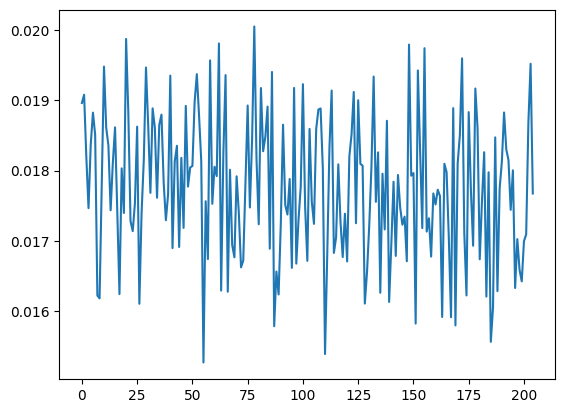

In [523]:
#visualise loss_list
import matplotlib.pyplot as plt
plt.plot(val_loss_list)
plt.show()

In [683]:
print(x_n)

In [456]:
a = Time_embed(64).to(device)
out = a(x_n.to(device))

In [457]:
n_events = x_n.mask.sum(-1)
seq_emb = out.sum(1) / torch.clamp(n_events[..., None], min=1)

In [458]:
seq_emb.shape

torch.Size([3, 64])

In [117]:
out = seq_emb.cpu().detach().numpy()


In [118]:
out = out
#use pca to reduce the dimentionality to 1
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
out = pca.fit_transform(out)

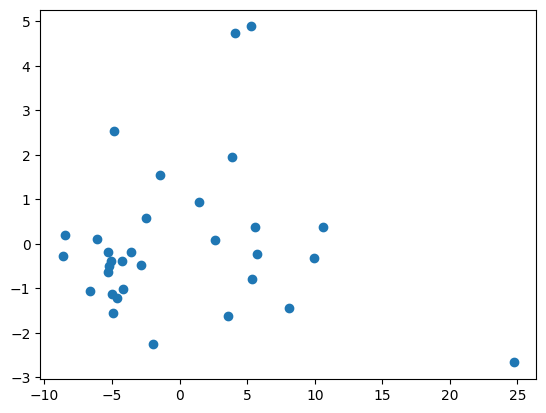

In [119]:
import matplotlib.pyplot as plt
plt.scatter(out[:, 0], out[:, 1])
plt.show()

In [120]:
n

tensor([0.8358, 0.0250, 0.6410, 0.1521, 0.4747, 0.6352, 0.3023, 0.2649, 0.1605,
        0.4678, 0.8366, 0.7202, 0.9508, 0.3766, 0.2682, 0.8674, 0.3451, 0.5874,
        0.2183, 0.1826, 0.7248, 0.3450, 0.2473, 0.8571, 0.7182, 0.5346, 0.4406,
        0.2463, 0.7848, 0.1910, 0.0552, 0.8151])

In [ ]:
class GaussianMixtures(nn.Module):
    def __init__(self, n_components):
        super(GaussianMixtures, self).__init__()
        self.n_components = n_components
        mus = torch.randn(size=(n_components,), requires_grad=True)
        sigmas = torch.abs(torch.randn(size=(n_components,), requires_grad=True))
        weights = torch.abs(torch.randn(size=(n_components,), requires_grad=True))
        self.mus = nn.Parameter(mus)
        self.sigmas = nn.Parameter(sigmas)
        self.weights = nn.Parameter(weights)
        
        
        
    def forward(self, seq_lens):
        mix = D.Categorical(probs=F.relu(self.weights))
        comp = D.Normal(loc=self.mus, scale=self.sigmas)
        mixture = D.MixtureSameFamily(mix, comp)
        log_probs = mixture.log_prob(seq_lens).mean()
        return log_probs
    
    def sample(self, n_samples):
        mix = D.Categorical(probs=F.relu(self.weights))
        comp = D.Normal(loc=self.mus, scale=self.sigmas)
        mixture = D.MixtureSameFamily(mix, comp)
        samples = mixture.sample((n_samples,))
        return samples
        
    
    

In [ ]:
from typing import Tuple

import torch
import torch.distributions as D
import torch.nn as nn
import warnings
from torch.distributions import MixtureSameFamily
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked

from add_thin.data import Batch
from add_thin.distributions.densities import DISTRIBUTIONS

patch_typeguard()


@typechecked
class MixtureIntensity(nn.Module):
    """
    Class parameterizing the intensity function as a weighted mixture of distributions.

    Parameters:
    ----------
    n_components : int, optional
        Number of components to use in the mixture, by default 10
    embedding_size : int, optional
        Size of the event embedding, by default 128
    distribution : str, optional
        Distribution to use for the components, by default "normal"

    """

    def __init__(
        self,
        n_components: int = 10,
        embedding_size: int = 128,
        distribution: str = "normal",
    ) -> None:
        super().__init__()

        assert (
            distribution in DISTRIBUTIONS.keys()
        ), f"{distribution} not in {DISTRIBUTIONS.keys()}"
        self.w_activation = torch.nn.Softplus()
        self.distribution = DISTRIBUTIONS[distribution]

        # Parallel compute parameters weight, mu and sigma for n components with one MLP
        self.n_components = n_components
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.ReLU(),
            nn.Linear(embedding_size, 3 * n_components),
        )
        self.rejections_sample_multiple = 2

    def get_intensity_parameters(
        self,
        embs
    ):
        """
        Compute the parameters of the intensity function.

        Parameters:
        ----------
        x_n : Batch
            Batch of event sequences to condition on
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time

        Returns:
        -------
        location, scale, weight: List[TensorType]
            The parameters of the intensity function
        """

        # Compute masked mean over sequence (zero padded)

        parameters = self.mlp(embs)
        return torch.split(
            parameters,
            [self.n_components, self.n_components, self.n_components],
            dim=-1,
        )

    def get_distribution(
        self,
        embs,
        x_n,
        L,
    ):
        """
        Instantiate the mixture-distribution parameterizing the intensity function.

        Parameters:
        ----------
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        x_n : Batch
            Batch of event sequences to condition on
        L : int
            Maximum sequence length

        Returns:
        -------
        density, cumulative_intensity: Tuple[D.MixtureSameFamily, TensorType[float, "batch"]]
            The distribution and the cumulative intensity
        """
        location, scale, weight = self.get_intensity_parameters(
            embs
        )

        # Include the number of events in x_n for the cumulative intensity
        weight = self.w_activation(weight)
        cumulative_intensity = (weight).sum(-1) * (x_n.mask.sum(-1) + 1)

        # Probs is normalized to sum to 1
        mixture_dist = D.Categorical(probs=weight.unsqueeze(1).repeat(1, L, 1))

        # Distribution parameters are the same for each sequence element
        component_dist = self.distribution(
            location.unsqueeze(1).repeat(1, L, 1),
            scale.unsqueeze(1).repeat(1, L, 1),
        )
        return (
            MixtureSameFamily(mixture_dist, component_dist),
            cumulative_intensity,
        )

    def log_likelihood(
        self,
        x_0,
        embs,
        x_n,
    ):
        """
        Compute the log-likelihood of the event sequences.

        Parameters:
        ----------
        x_0 : Batch
            Batch of event sequences
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        x_n : Batch
            Batch of event sequences to condition on

        Returns:
        -------
        log_likelihood: TensorType[float, "batch"]
            The log-likelihood of the event sequences
        """
        density, cif = self.get_distribution(
            embs=embs,
            x_n=x_n,
            L=x_0.seq_len,
        )

        # Normalize event time to [0, 1]
        x = x_0.time / x_0.tmax

        # Compute log-intensity with re-weighting
        log_intensity = (
            (density.log_prob(x) + torch.log(cif)[..., None]) * x_0.mask
        ).sum(-1)

        # Compute CIF for normalization
        cdf = density.cdf(torch.ones_like(x)).mean(1)
        cif = cif * cdf  # Rescale between 0 and T

        return log_intensity - cif

    def sample(
        self,
        embs,
        n_samples,
        x_n,
    ):
        """
        Sample event sequences from the intensity function.

        Parameters:
        ----------
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        n_samples : int
            Number of samples to draw
        x_n : Batch
            Batch of event sequences to condition on

        Returns:
        -------
        Batch
            The sampled event sequences
        """
        tmax = x_n.tmax
        density, cif = self.get_distribution(
            embs=embs,
            x_n=x_n,
            L=1,
        )

        # Get number of points per sample sequence from CIF
        count_distribution = D.Poisson(
            rate=cif * density.cdf(torch.ones_like(x_n.time)).mean().squeeze()
        )
        sequence_len = (
            count_distribution.sample((n_samples,)).squeeze()
        ).long()

        # TODO implement smarter truncated normal, without rejection sampling.
       

        return sequence_len

In [ ]:

    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)
        
        

In [ ]:
#set detect anomaly to True
with torch.autograd.detect_anomaly():
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(200)):
        train_batch_list = []
        for batch in train_loader:
            
            optimizer.zero_grad()
            n = torch.randint(low = 1, high = 10, size=(len(batch),), device=batch.time.device)
            #n = torch.ones_like(n) * 3
            #l = n.shape[0]
            #n[:l//3] =a n[:l//3] * 3
            #n[l//3:2*l//3] =  n[l//3:2*l//3] * 2
            #n[2*l//3:] = n[2*l//3:] * 1
            n = n/10 
            x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
            x_n.to(device)
            x_0_thin.to(device)
            preds = model(x_n,n)
            preds = 140 * preds
            
            #mse loss between x_o_thin and preds
            loss = F.mse_loss(preds.squeeze(), x_0_thin.unpadded_length.float())
            #loss = 0
            loss.backward()
            optimizer.step()
            # if epoch is divisble by 100 print the loss
                
            train_batch_list.append(loss.item())
            
        with torch.no_grad():
            #evaluate on val_loader
            val_batch_list = []
            for batch in val_loader:
                n = torch.randint(low = 5, high = 10, size=(len(batch),), device=batch.time.device)
                n = n/10
                x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
                x_n.to(device)
                x_0_thin.to(device)
                preds = model(x_n,n)
                preds = 140 * preds
                loss = F.mse_loss(preds.squeeze(), x_0_thin.unpadded_length.float())
                val_batch_list.append(loss.item())
            print("epoch: ", epoch, "val_loss: ", sum(val_batch_list)/len(val_batch_list))
            
        train_loss_list.append(sum(train_batch_list)/len(train_batch_list))
        val_loss_list.append(sum(val_batch_list)/len(val_batch_list))
        if epoch % 10 == 0:
                #print("epoch: ", epoch, "train_loss: ", train_loss_list[-1])
                print("epoch: ", epoch, "val_loss: ", val_loss_list[-1])
        
        

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class CVAE1D(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(CVAE1D, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder layers
        self.encoder_fc1 = nn.Linear(2*input_dim, hidden_dim)
        self.encoder_fc2_mean = nn.Linear(hidden_dim, hidden_dim)
        self.encoder_fc2_logvar = nn.Linear(hidden_dim, hidden_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, 1)

    def encode(self, x, context):
        # Concatenate input x with context embeddings
        x = torch.cat([x, context], dim=1)
        #x = context
        x = F.relu(self.encoder_fc1(x))
        z_mean = self.encoder_fc2_mean(x)
        z_logvar = self.encoder_fc2_logvar(x)
        return z_mean, z_logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, context):
        # Concatenate latent z with context embeddings
        z = torch.cat([z, context], dim=1)
        z = F.relu(self.decoder_fc1(z))
        x_recon = torch.sigmoid(self.decoder_fc2(z))  # Sigmoid activation for output
        return x_recon

    def forward(self, x,context):
        # Encode
        z_mean, z_logvar = self.encode(x,context)
        # Reparameterize
        z = self.reparameterize(z_mean, z_logvar)
        # Decode
        x_recon = self.decode(z, context)
        return x_recon, z_mean, z_logvar

    def sample(self, context):
        # Sample from the prior and decode
        num_samples = context.size(0)
        z = torch.randn([num_samples, self.hidden_dim]).to(context.device)
        x_recon = self.decode(z, context)
        return x_recon


In [ ]:
def plot_gmm_components(model):
    mus = model.mus.detach().numpy()
    sigmas = model.sigmas.detach().numpy()
    weights = F.relu(model.weights).detach().numpy()

    # Plot individual Gaussian components
    plt.figure(figsize=(8, 6))
    for i in range(model.n_components):
        mean = mus[i]
        std_dev = sigmas[i]
        weight = weights[i]

        x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
        y = weight * np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (np.sqrt(2 * np.pi) * std_dev)
        plt.plot(x, y, label=f"Component {i+1}", linewidth=2)

    plt.title("Gaussian Mixture Model Components")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [ ]:
#set detect anomaly to True
with torch.autograd.detect_anomaly():
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(1000)):
        train_batch_list = []
        for batch in train_loader:
            optimizer.zero_grad()
            n = torch.randint(low = 0, high = 10, size=(len(batch),), device=batch.time.device) * 0
            n = n/10 
            x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
            x_n.to(device)
            x_0_thin.to(device)
            x_0_thin_lens = x_0_thin.unpadded_length
            x_0_thin_lens = x_0_thin_lens.float()
            len_embs = n_embed(x_0_thin_lens).squeeze(1)
            x0 = torch.rand_like(len_embs)
            x1 = len_embs
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
            t = t.to(device)
            xt = xt.to(device)
            ut = ut.to(device)
            vt = model(torch.cat([xt, t[:, None]], dim=-1))
            loss = torch.mean((vt - ut) ** 2)
            reconstruct_loss = F.mse_loss(embs_to_len(len_embs).squeeze(), x_0_thin_lens)
            loss = loss + reconstruct_loss
            loss.backward()
            optimizer.step()
            train_batch_list.append(loss.item())
            
        with torch.no_grad():
            #evaluate on val_loader
            val_batch_list = []
            for batch in val_loader:
                n = torch.randint(low = 0, high = 10, size=(len(batch),), device=batch.time.device) * 0
                n = n/10
                x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
                x_n.to(device)
                x_0_thin.to(device)
                x_0_thin_lens = x_0_thin.unpadded_length
                x_0_thin_lens = x_0_thin_lens.float()
                len_embs = n_embed(x_0_thin_lens).squeeze(1)
                x0 = torch.rand_like(len_embs)
                x1 = len_embs
                t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
                t = t.to(device)
                xt = xt.to(device)
                ut = ut.to(device)
                vt = model(torch.cat([xt, t[:, None]], dim=-1))
                loss = torch.mean((vt - ut) ** 2)
                reconstruct_loss = F.mse_loss(embs_to_len(len_embs).squeeze(), x_0_thin_lens)
                loss = loss + reconstruct_loss
                val_batch_list.append(loss.item())
                
            
        train_loss_list.append(sum(train_batch_list)/len(train_batch_list))
        val_loss_list.append(sum(val_batch_list)/len(val_batch_list))
        if epoch % 10 == 0:
                #clear output of jupyter notebook screen
                clear_output(wait=True)
                print("epoch: ", epoch, "val_loss: ", val_loss_list[-1])
                
    
                    
                
        
        